In [7]:
!pip uninstall opencv-contrib-python -y
!pip uninstall opencv-python -y
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Successfully uninstalled opencv-contrib-python-4.11.0.86


You can safely remove it manually.


Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl (46.2 MB)


ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device



In [8]:
# Imported Libraries
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
import warnings
warnings.filterwarnings("ignore")

from utils.visualization import visualize_detections, print_detections
from utils.matchers import find_matcher_matrix
from utils.bbox_filtering import find_bboxes

# Images Path
scene_folder = './images/scenes/'
model_folder = './images/models/'
video_folder = './images/videos/'
results_folder = './images/results/'
#reloads external modules when they are changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Lists with the scenes and models of Step B
valid_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
model_filenames = [f for f in os.listdir(model_folder) if f.lower().endswith(valid_extensions)]
scene_filenames = ['e4.png']

# Read images
im_scene_list_original = [cv2.cvtColor(cv2.imread(scene_folder + name), cv2.COLOR_BGR2RGB) for name in scene_filenames]
im_model_list_original = [cv2.cvtColor(cv2.imread(model_folder + name), cv2.COLOR_BGR2RGB) for name in model_filenames]

In [10]:
im_model_list = []
model_labels = []

for im, label in zip(im_model_list_original, model_filenames):
    aspect = im.shape[0]/im.shape[1]
    #resize model images
    for s in (360,):
        im_resized = cv2.resize(im, (s, int(s*aspect)))
        im_model_list.append(im_resized)
        model_labels.append(label)

    #gaussian blur on original images
    for sigma in (1.5, 3, 5):
        k = int(np.ceil(3*sigma))
        im_model_list.append(cv2.GaussianBlur(im, (2*k+1, 2*k+1), sigma))
        model_labels.append(label)

In [11]:
model_names = {}
for name in listdir(model_folder):
    simplified_name = name.rsplit('_', 1)[-1].split('.')[0]
    model_names[name] = simplified_name

In [12]:


### Initialization of Super Resolution 
train_dict = {1: ['fsrcnn', './weights/FSRCNN-small_x4.pb'],
              2: ['espcn', './weights/ESPCN_x4.pb'],
              3: ['edsr', './weights/EDSR_x4.pb'],
              4: ['lapsrn', './weights/LapSRN_x4.pb']}
nn_used = 4

sr = cv2.dnn_superres.DnnSuperResImpl_create()
sr.readModel(train_dict[nn_used][1])
sr.setModel(train_dict[nn_used][0], 4)

# upsample scene images
im_scene_list = [sr.upsample(im) for im in im_scene_list_original]
#im_scene_list = im_scene_list_original

#save preprocessed images
#new_scene_folder = f"images/results/upscaled_scenes/upscaled_{nn_used}/"
#for im_scene, filename in zip(im_scene_list, scene_filenames):
#    cv2.imwrite(new_scene_folder + filename, cv2.cvtColor(im_scene, cv2.COLOR_RGB2BGR))



error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 400128000 bytes in function 'cv::OutOfMemoryError'


In [ ]:
#set the ransac reprojection threshold when computing the homography
homography_kw = dict(match_distance_threshold = 0.88, ransacReprojThreshold = 1.)
peaks_kw = dict(height = 0.3, distance = 0)

#compute matcher matrix
matcher_matrix = find_matcher_matrix(im_scene_list, im_model_list, K=15, peaks_kw=peaks_kw, homography_kw=homography_kw)

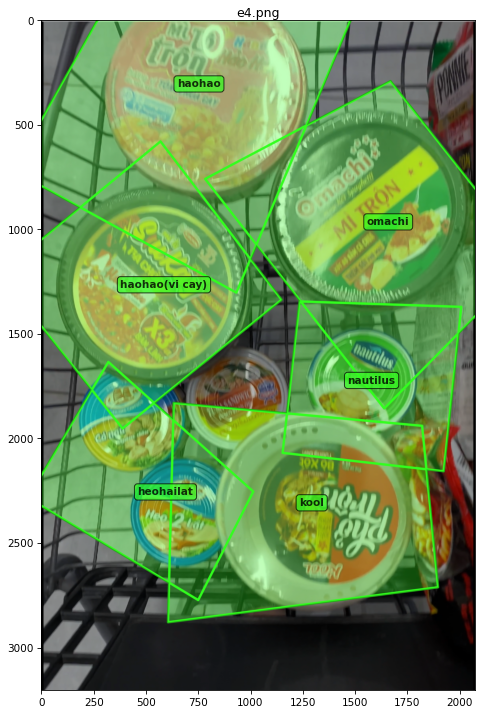

	Product haohao - 1 instance found:
		Instance 1: (position: (749, 319), width: 1134px, height: 1454px)
	Product haohao(vi cay) - 1 instance found:
		Instance 1: (position: (478, 1279), width: 948px, height: 987px)
	Product heohailat - 1 instance found:
		Instance 1: (position: (560, 2270), width: 939px, height: 668px)
	Product kool - 1 instance found:
		Instance 1: (position: (1333, 2322), width: 1245px, height: 912px)
	Product nautilus - 1 instance found:
		Instance 1: (position: (1564, 1737), width: 773px, height: 759px)
	Product omachi - 1 instance found:
		Instance 1: (position: (1656, 979), width: 1000px, height: 1238px)


In [ ]:
new_labels = [model_names[l] for l in model_labels]

grand_total = 0  # Initialize grand total for all scenes
detected_items = []  # List to store detected items and their prices

for i in range(len(im_scene_list)):
    scene_name = scene_filenames[i]

    color_threshold = 15
    overlap_threshold = 0.5
    bbox_props = find_bboxes(matcher_matrix[i], new_labels, color_distance_threshold=color_threshold, min_match_threshold=6, bbox_overlap_threshold=overlap_threshold)

    w, h, dpi = 960, 720, 75
    fig, ax = plt.subplots(figsize=(w/dpi, h/dpi), dpi=dpi)
    
    visualize_detections(im_scene_list[i], bbox_props, annotation_offset=100, ax=ax, draw_invalid_bbox=(0))
    fig.suptitle(scene_name)
    fig.tight_layout(pad=0.5)
    #fig.savefig('images/results/found_' + scene_name)
    plt.show()
    
    print_detections(bbox_props)

In [ ]:
txt_file = results_folder + "detected_items.txt"
with open(txt_file, "w") as f:
    for item in detected_items:
        f.write(f"Product: {item['product']}\n")
        f.write(f"Price: {item['price']:.2f}\n")
        f.write("\n")

print(f"Detected items exported to {txt_file}")
print(f"Grand total price for all scenes: ${grand_total:.2f}")

bbox_props: [{'model': 'haohao(vi cay)', 'corners': array([[[ 565.7155 ,  536.28046]],

       [[-203.72278, 1218.0049 ]],

       [[ 403.74976, 1911.6372 ]],

       [[1141.7719 , 1340.3634 ]]], dtype=float32), 'center': array([ 477.96814, 1281.8647 ], dtype=float32), 'match_number': 86, 'sufficient_matches': True, 'valid_shape': True, 'color_distance': 1.0641313922375475, 'valid_color': True, 'valid_bbox': False}, {'model': 'haohao(vi cay)', 'corners': array([[[ 569.0888 ,  564.04755]],

       [[-215.41243, 1215.455  ]],

       [[ 397.32327, 1925.8921 ]],

       [[1137.1035 , 1343.695  ]]], dtype=float32), 'center': array([ 478.45145, 1283.1027 ], dtype=float32), 'match_number': 85, 'sufficient_matches': True, 'valid_shape': True, 'color_distance': 1.010101097665701, 'valid_color': True, 'valid_bbox': False}, {'model': 'haohao(vi cay)', 'corners': array([[[ 623.75116, 2191.6147 ]],

       [[1571.8926 , 1870.1704 ]],

       [[ 884.9664 , 2079.5605 ]],

       [[ 351.25208, 2205.3